<a href="https://colab.research.google.com/github/normandipalo/mini-push-for-her/blob/master/mini_push_her.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
%matplotlib inline

## Create the environment. 
An agent pushes a block in a grid-world, and must reach a speicfied position with only sparse rewards.

In [0]:


class World():
    def __init__(self):
        self.map = np.zeros((5,5))
        self.observation_space = self.observation()
        self.action_space = self.action_sp()
        self.agent = np.array([0.,0.])
        self.cube = np.array([2.,2.])
        self.goal = np.array([3.,3.])
        
    def reset(self):
        self.map = np.zeros((5,5))
        self.agent = np.random.randint(0, 4, size = (2)).reshape((2))
        self.agent = np.array(self.agent, dtype = np.float32)
        self.cube = np.random.randint(1, 3, size = (2)).reshape((2))
        self.cube = np.array(self.cube, dtype = np.float32)
        while (self.agent == self.cube).all():
            self.cube = np.random.randint(1, 3, size = (2)).reshape((2))
            self.cube = np.array(self.cube, dtype = np.float32)
            
        self.goal = np.random.randint(0, 4, size = (2)).reshape((2))
        self.goal = np.array(self.cube, dtype = np.float32)
        while (self.goal == self.cube).all():
            self.goal = np.random.randint(0, 4, size = (2)).reshape((2))
            self.goal = np.array(self.goal, dtype = np.float32)
            
        return np.concatenate((self.agent, self.cube, self.goal), axis = 0)
    
    def _move_agent(self, action):
        self.agent = self.agent + np.array(action)
        self.agent = np.clip(self.agent, 0., 4.)
    
    def step(self, action):
        old_agent = self.agent.copy()
        self._move_agent(action)
        new_agent = self.agent.copy()
        if (new_agent == self.cube).all():
            delta = new_agent - old_agent
            delta = np.array(delta, dtype = np.float32)
            self.cube+=delta
        reward = -1.
        done = False
        if (self.cube == self.goal).all():
            reward = 1.
            done = True
        
        return np.concatenate((self.agent, self.cube, self.goal), axis = 0), reward, done, {"hello": "world"}
    
    def show(self):
        mappa = self.map.copy()
        mappa[int(self.agent[0]), int(self.agent[1])] = 1.
        mappa[int(np.clip(self.cube[0], 0, 4)), int(np.clip(self.cube[1], 0, 4))] = 2.
        mappa[int(np.clip(self.goal[0], 0, 4)), int(np.clip(self.goal[1], 0, 4))] = 3.
        print(mappa)
        
    class observation():
        def __init__(self):
            self.shape = [6]

    class action_sp():
        def __init__(self):
            self.shape = [2]

        def sample(self):
            act = np.array([np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype = np.float32)
            return act

In [0]:
from collections import deque
from copy import deepcopy

In [0]:
def evaluate_trans(state, action, next_state):
    if np.linalg.norm((next_state[2:4] - next_state[-2:])) < 0.1:
        done = True
        reward = 1.
    else:
        done = False
        reward = -1.
    return reward, done

## Deep Deterministic Policy Gradient.
Create the various classes and functions needed to perform DDPG, such as Policy and Value Networks, Target Networks, Replay Buffer etc.

In [0]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)
      
class ValueNetwork(tf.keras.Model):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w = 3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = tf.keras.layers.Dense(units = hidden_size, activation = "relu")
        self.linear2 = tf.keras.layers.Dense(units = hidden_size, activation = "relu")
        self.linear3 = tf.keras.layers.Dense(units = 1, kernel_initializer = tf.keras.initializers.RandomUniform(minval = -init_w, maxval = init_w), bias_initializer = tf.keras.initializers.RandomUniform(minval = -init_w, maxval = init_w))
        
    def call(self, state, action):
        action = tf.convert_to_tensor(action) #serve?
        state = tf.convert_to_tensor(state)
        x = tf.concat((action, state), axis = 1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x
    
class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w = 3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = tf.keras.layers.Dense(units = hidden_size, activation = "relu")
        self.linear2 = tf.keras.layers.Dense(units = hidden_size, activation = "relu")
        self.linear3 = tf.keras.layers.Dense(units = num_actions, activation = "tanh", kernel_initializer = tf.keras.initializers.RandomUniform(minval = -init_w, maxval = init_w),  bias_initializer = tf.keras.initializers.RandomUniform(minval = -init_w, maxval = init_w))
        
    def call(self, state):
        state = tf.convert_to_tensor(state)
        x = self.linear1(state)
        x = self.linear2(x)
        x = self.linear3(x)
        x = x*1
        return x
    
    def get_action(self, state):
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action = self.call(state)
        return action.numpy().squeeze(0) #detach -> stop gradients?
      
pol_losses = []
val_losses = []
def ddpg_update(batch_size, gamma = 0.9, min_value = -np.inf,
                max_value = np.inf, soft_tau1 = 1e-1, soft_tau2 = 1e0, replay_buffer = None):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    PRINT = False
    #al posto di expand dims potrei quando possibile expandere il numpy con[None,:]
    state = tf.convert_to_tensor(state, dtype = tf.float64)
    if PRINT: print("state shape", state.numpy().shape)
    next_state = tf.convert_to_tensor(next_state, dtype = tf.float64)
    if PRINT: print("next state shape", next_state.numpy().shape)
    action = tf.convert_to_tensor(action, dtype = tf.float64)
    if PRINT: print("action shape", action.numpy().shape)
    reward = tf.expand_dims(tf.convert_to_tensor(reward, dtype = tf.float64),1)
    if PRINT: print("reward shape", reward.numpy().shape)
    done = tf.expand_dims(tf.convert_to_tensor(np.float32(done), dtype = tf.float64), axis = 1)
    
    if PRINT: print("done shape", done.numpy().shape)
    with tf.GradientTape() as tape:
        policy_loss = value_net(state, policy_net(state))
        policy_loss = -tf.reduce_mean(policy_loss)
        pol_losses.append(policy_loss)
        if PRINT: print("Policy Loss", policy_loss)
        policy_grads = tape.gradient(policy_loss, policy_net.variables)
        
    #    print("Policy Grads", [tf.reduce_mean(policy_grad).numpy() for policy_grad in policy_grads]) 
        policy_optimizer.apply_gradients(zip(policy_grads, policy_net.variables),
                            global_step=tf.train.get_or_create_global_step())
    
    with tf.GradientTape() as tape:
        
        #rimetti target
        next_action = target_policy_net(next_state)
        target_value = target_value_net(next_state, tf.stop_gradient(next_action)) #next action è un tensore che arriva
        expected_value = reward + (1.0 - done)*gamma*target_value             #da una rete quindi per questo dobbiamo impedire che venga backprop
        
        
        value = value_net(state, action)
        if PRINT: print("value shape", value.numpy().shape)
        if PRINT: print("exp value shape", expected_value.numpy().shape)
        value_loss = tf.losses.mean_squared_error(tf.stop_gradient(expected_value), value)
        val_losses.append(value_loss)
   #     value_loss = tf.reduce_mean(tf.square((tf.stop_gradient(expected_value) - value)))
        if PRINT: print("Value Loss", value_loss)

        value_grads = tape.gradient(value_loss, value_net.variables)
        value_optimizer.apply_gradients(zip(value_grads, value_net.variables),
                            global_step=tf.train.get_or_create_global_step())
    
    for target_param, param in zip(target_value_net.variables, value_net.variables):
        tf.assign(target_param, (target_param*(1.0 - soft_tau1) + param * soft_tau1))
        
    for target_param, param in zip(target_policy_net.variables, policy_net.variables):
        tf.assign(target_param, (target_param*(1.0 - soft_tau1) + param * soft_tau1))
   
    for target_param, param in zip(target2_value_net.variables, target_value_net.variables):
        tf.assign(target_param, (target_param*(1.0 - soft_tau2) + param * soft_tau2))
        
    for target_param, param in zip(target2_policy_net.variables, target_policy_net.variables):
        tf.assign(target_param, (target_param*(1.0 - soft_tau2) + param * soft_tau2))
        
N = False
env = World()
print(env.action_space.shape)


state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  if not N else env.action_space.n
hidden_dim = 50

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)

#Actually initialize network, otherwise it has no weights 
value_net(tf.convert_to_tensor(np.random.randn(1,state_dim)), action = tf.convert_to_tensor(np.random.randn(1,action_dim)))
policy_net(tf.convert_to_tensor(np.random.randn(1, state_dim)))

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)

#Actually initialize network, otherwise it has no weights
target_value_net(tf.convert_to_tensor(np.random.randn(1,state_dim)), action = tf.convert_to_tensor(np.random.randn(1,action_dim)))
target_policy_net(tf.convert_to_tensor(np.random.randn(1, state_dim)))


for target_param, param in zip(target_value_net.variables, value_net.variables):
    tf.assign(target_param , param)

for target_param, param in zip(target_policy_net.variables, policy_net.variables):
    tf.assign(target_param , param)
    
target2_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim)
target2_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)

#Actually initialize network, otherwise it has no weights
target2_value_net(tf.convert_to_tensor(np.random.randn(1,state_dim)), action = tf.convert_to_tensor(np.random.randn(1,action_dim)))
target2_policy_net(tf.convert_to_tensor(np.random.randn(1, state_dim)))

for target_param, param in zip(target2_value_net.variables, value_net.variables):
    tf.assign(target_param , param)

for target_param, param in zip(target2_policy_net.variables, policy_net.variables):
    tf.assign(target_param , param)

value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer = tf.train.AdamOptimizer(learning_rate = value_lr)
policy_optimizer = tf.train.AdamOptimizer(learning_rate = policy_lr)

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)
        

[2]


## Hindsight Experience Replay.
Define the HER algorithm, which takes an experienced trajectory, stores it into buffer and also stores a modified trajectory substituting the goal with future reached stated.

In [0]:
def herify(states, actions, rewards, next_states, dones, buffer):
        T = len(states)
        for t in range(T-1):
            buffer.push(states[t].copy(), actions[t].copy(), rewards[t], next_states[t].copy(), dones[t])
            for k in range(4):
                future_step = np.random.randint(t+1,T)
                future_goal = next_states[future_step][2:4]
                state_f = deepcopy(states[t])
                
                if np.linalg.norm((state_f[2:4] - future_goal)) < 0.1: #se il goal fututo è già realizzato skippa
                    continue
                
                state_f[-2:] = future_goal
                next_state_f = deepcopy(next_states[t])
                next_state_f[-2:] = future_goal
                r_f, d_f = evaluate_trans(state_f, actions[t], next_state_f)
                buffer.push(state_f, actions[t], r_f, next_state_f, d_f)
                

In [0]:
replay_buffer = ReplayBuffer(100000)

In [0]:
def ev_policy():
    fails, wins = 0,0
    for i in range(100):
        env = World()
        state = env.reset()
        done = False
        st = 0
        while not done:
            st+=1
            if st == 30: 
                done = True
                fails+=1
                break
            act = policy_net.get_action(np.array(state, dtype = np.float64))
            act = np.array(act, dtype = np.float64)
            state = np.array(state, dtype = np.float64)
       #     print("value", value_net(state.reshape((1,-1)), act.reshape((1,-1))))
            act += np.random.randn(2)*0.1
        #    print(act)
            for a in range(len(act)):
                if act[a] < -0.3 : act[a] = -1.
                if act[a] > -0.3 and act[a] < 0.3: act[a] = 0.
                if act[a] > 0.3: act[a] = 1.
        #    print(act)
            next_state, reward, done, _ = env.step(act)
            if reward==1:
                wins+=1
        #    print(next_state)
        #    env.show()
            state = next_state
        #    print("REWARD", reward, "DONE", done)
    return wins

## Training phase.

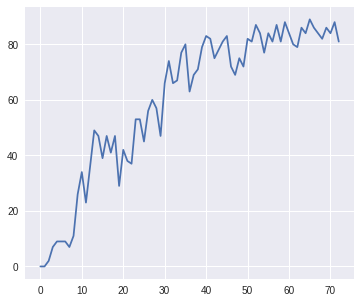

KeyboardInterrupt: ignored

In [0]:
#generate rollout
winslist = []
states, actions, rewards, next_states, dones = [], [], [], [], []
env = World()
for i in range(500000):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    state = env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        act =policy_net.get_action(np.array(state, dtype = np.float64))
        act += np.random.randn(2)*0.1
        act_disc = deepcopy(act)
        for a in range(len(act)):
            if act[a] < -0.3 : act_disc[a] = -1.
            if act[a] > -0.3 and act[a] < 0.3: act_disc[a] = 0.
            if act[a] > 0.3: act_disc[a] = 1.
        next_state, reward, done, _ = env.step(act_disc)
        if steps > 30: break
        states.append(state)
        actions.append(act)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        state = next_state
    herify(states, actions, rewards, next_states, dones, replay_buffer)
    if i % 10 == 0 and not i == 0:
        for k in range(10):
            if len(replay_buffer) > 128:
              ddpg_update(64, replay_buffer=replay_buffer)
    if i % 501 == 0:
        wins = 0
        
        wins+=ev_policy()
        winslist.append(wins)
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.plot(winslist)
        plt.show()

In [0]:
def show(state):
  import time
  mappa = np.ones((5,5,3))
  agent = state[:2]
  cube = state[2:4]
  goal = state[4:]
  mappa[int(agent[0]), int(agent[1]),:] = [0.,0.,0.]
  mappa[int(cube[0]), int(cube[1]), :] = [1.,0.,0.]
  mappa[int(goal[0]), int(goal[1]), :] = [0.,1.,0.]
  clear_output(True)
  plt.imshow(mappa)
  plt.show()
  time.sleep(1)

## Visualize the agent.
Visualize what the agent is doing in this interactive plotting of the environment. The agent is black, the cube is red, the goal is green.

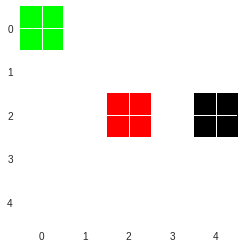

KeyboardInterrupt: ignored

In [0]:
fails, wins = 0,0
for i in range(100):
    env = World()
    state = env.reset()
    done = False
    st = 0
    while not done:
        st+=1
        if st == 30: 
            done = True
            fails+=1
            break
        act = policy_net.get_action(np.array(state, dtype = np.float64))
        act = np.array(act, dtype = np.float64)
        state = np.array(state, dtype = np.float64)
   #     print("value", value_net(state.reshape((1,-1)), act.reshape((1,-1))))
        act += np.random.randn(2)*0.1
    #    print(act)
        for a in range(len(act)):
            if act[a] < -0.3 : act[a] = -1.
            if act[a] > -0.3 and act[a] < 0.3: act[a] = 0.
            if act[a] > 0.3: act[a] = 1.
    #    print(act)
        next_state, reward, done, _ = env.step(act)
        if reward==1:
            wins+=1
    #    print(next_state)
        env.show()
        state = next_state
        show(state)
    #    print("REWARD", reward, "DONE", done)